### PINN approach for the 1-D duffing problem

$\ddot{u} + 2D\dot{u} + \omega_0^2(u + \mu u^3) = f(t)$

In [1]:
import torch
import torch.nn as nn
import torchphysics as tp
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import chirp, unit_impulse
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from torchinfo import summary

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Training on', device)
print ("GPU available: " + str(torch.cuda.is_available()))

Training on cuda:1
GPU available: True


In [3]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [4]:
omega_0 = 1

ode_params = {'D': .1,      # damping constant
              'c_nlin': 0.75  # nonlinearity
             }
sampling_frequency = 32 
t_end = 36 # sec
time = np.linspace(0, t_end, t_end*sampling_frequency + 1)
time_ind = pd.to_timedelta(time, unit="sec")
f_fac = 1.
x0 = [0, 0.5] # initial conditions [x0, v0]

### ODE solution

In [5]:
def duffing(t, y, D, c_nlin, F_func):
    z1, z2 = y
    dz1dt = z2
    dz2dt = - 2 * D * z2 - z1 - c_nlin * z1**3 + f_fac *  F_func(t)
    return(dz1dt, dz2dt)

def interfunc(data, k=1):
    return IUS(data.index.to_numpy().ravel(), data, k=k)

def get_rk_solution(func, t_1, time_eval):
    numeric_solu = solve_ivp(duffing,
                         t_span=(0, t_1),
                         y0 = x0,
                         max_step=1 / sampling_frequency,
                         args=(ode_params['D'], ode_params['c_nlin'], func),
                         t_eval=time_eval,
                        )

    solu = pd.Series(numeric_solu.y[0,:], index=pd.Index(numeric_solu.t, name="time"), name="Runge-Kutta")
    return solu

In [6]:
chirpfunc = chirp(time, f0=0.1, t1=time.max(), f1=10, method='linear', phi=-90)
F = pd.DataFrame([np.random.randn(time.shape[0]),
              chirpfunc,
              chirpfunc + 0.5 * np.random.randn(time.shape[0]),
              unit_impulse(time.shape[0]),
#               np.zeros(time.shape[0])
                 ],
              columns=pd.Index(time, name="time"),
              index=["wn", "SineSweep", "SoR", "Dirac"]
              ).T

func_f = F.apply(interfunc)
rk_solu = func_f.apply(get_rk_solution,**{"t_1":t_end, "time_eval":time}).T

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

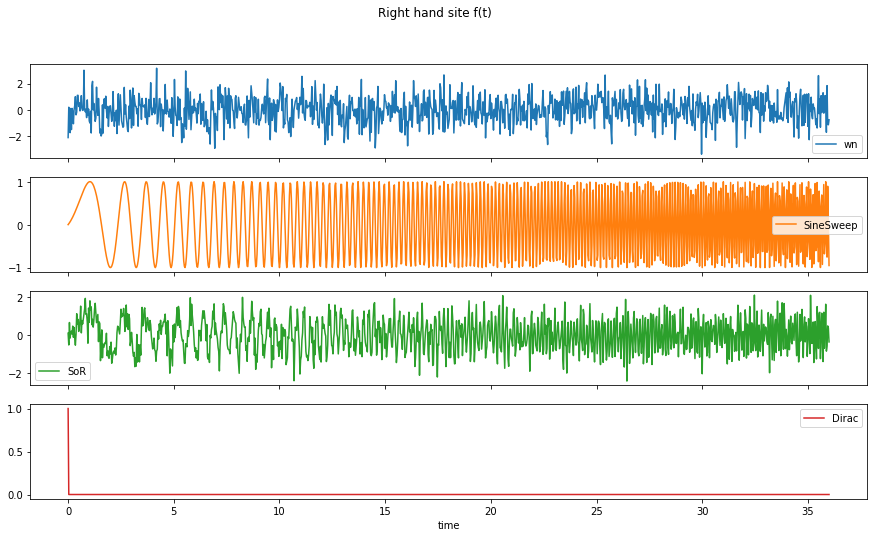

In [7]:
%matplotlib inline
F.plot(title="Right hand site f(t)", figsize=(15,8), subplots=True)

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

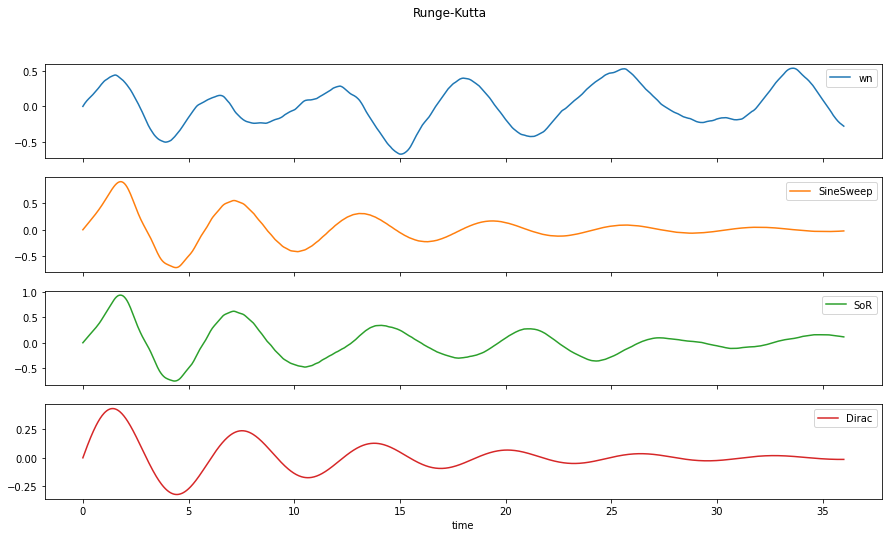

In [8]:
rk_solu.plot(figsize=(15,8), subplots=True, title="Runge-Kutta")   

### PINN solution

In [9]:
T = tp.spaces.R1('t') # time
# Output
U = tp.spaces.R1('u')
# Intervals and domains and sampler
Dmin, Dmax = 0.01, 0.1
A_t = tp.domains.Interval(T, -0.05, t_end)
inner_sampler = tp.samplers.GridSampler(A_t, n_points = 2048)#.make_static()
initial_u_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()
initial_v_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()

In [10]:
inner_sampler.sample_points()

Points:
{'t': tensor([[-3.2406e-02],
        [-1.4812e-02],
        [ 2.7818e-03],
        ...,
        [ 3.5947e+01],
        [ 3.5965e+01],
        [ 3.5982e+01]])}

<AxesSubplot:title={'center':'Right hand site f(t)'}, xlabel='time'>

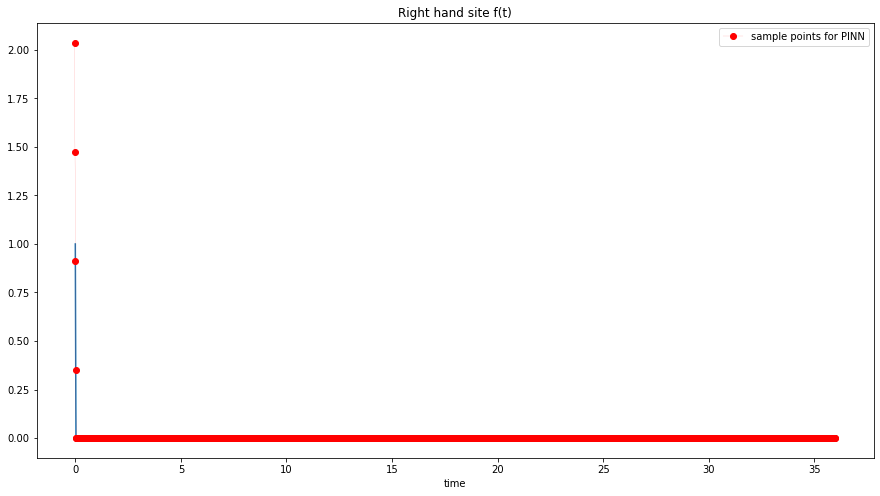

In [11]:
_eval = "Dirac" #"wn"
f, ax = plt.subplots(figsize=(15,8))
F[_eval].plot(title="Right hand site f(t)", ax=ax)
F_inter_func = func_f[_eval]
pd.DataFrame(F_inter_func(inner_sampler.sample_points().as_tensor.numpy().ravel()),
          index=pd.Index(inner_sampler.sample_points().as_tensor.numpy().ravel(),name="time"),
          columns=["sample points for PINN"]).plot(
              # x="time", y="sample points for PINN",
              marker="o",
              color="r",
              linestyle=None,
              linewidth=0.1,
               ax=ax
              )

In [34]:
#%% Model Definition
class Snake(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        a = 1
        return Tensor + (1.0/a) * torch.pow(torch.sin(Tensor * a), 2)

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        return torch.sin(Tensor)
    
class DampedSine(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        alpha = 0.1
        return torch.exp(-alpha * Tensor) * torch.sin(Tensor)

model = tp.models.FCN(input_space=T, output_space=U, hidden=(32, 32, 16, 6, 4),
                      activations=DampedSine() #Tanh(), RNN()
#                       activations=[Snake(), DampedSine(), Snake()] #Tanh(), RNN()
                      )
summary(model, input_size=None)

Layer (type:depth-idx)                   Param #
FCN                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       64
│    └─DampedSine: 2-2                   --
│    └─Linear: 2-3                       1,056
│    └─DampedSine: 2-4                   --
│    └─Linear: 2-5                       528
│    └─DampedSine: 2-6                   --
│    └─Linear: 2-7                       102
│    └─DampedSine: 2-8                   --
│    └─Linear: 2-9                       28
│    └─DampedSine: 2-10                  --
│    └─Linear: 2-11                      5
Total params: 1,783
Trainable params: 1,783
Non-trainable params: 0

In [35]:
def right_hand_side(t):
    rhs = f_fac * torch.tensor(F_inter_func(t.detach().cpu().numpy()))
    return rhs.cuda()

def duffing_residual(u, t, right_hand_side):
    pde_homo = tp.utils.laplacian(u, t)  + 2 * ode_params["D"] * tp.utils.grad(u, t) \
            + omega_0**2 * u + ode_params["c_nlin"] * u**3
    return pde_homo #- right_hand_side 
            
pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=duffing_residual,
                                            data_functions={'right_hand_side': right_hand_side},
                                            name='pde_condition',
                                            weight=10.0)

def initial_u_residual(u):
    return u - x0[0]
initial_u_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=initial_u_sampler,
                                                     residual_fn=initial_u_residual,
                                                     name='ic_u')

def initial_v_residual(u, t):
    return tp.utils.grad(u, t) - x0[1]
initial_v_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=initial_v_sampler,
                                                     residual_fn=initial_v_residual,
                                                     name='ic_v')
def rhs_residual(u, right_hand_side):
    return right_hand_side - u

rhs_condition = tp.conditions.PINNCondition(module=model,
                                    sampler=inner_sampler,
                                    residual_fn=rhs_residual,
                                    data_functions={'right_hand_side': right_hand_side},
                                    name='rhs',
                                    weight=12)

In [36]:
gpus_switch = 1 if torch.cuda.is_available() else None
gpus_switch
#%% Training
# for opti, steps in zip([torch.optim.AdamW], [50]):
for opti, steps in zip([torch.optim.AdamW, torch.optim.LBFGS], [5000, 240]):
    opt_setting = tp.solver.OptimizerSetting(opti, lr=1e-2) #AdamW, SGD, LBFGS
    solver = tp.solver.Solver([pde_condition,
                               initial_u_condition,
                               initial_v_condition,
                               rhs_condition
                              ], optimizer_setting = opt_setting)
    
    trainer = pl.Trainer(gpus=gpus_switch,
                         max_steps = steps,
                         logger=True, 
                         benchmark=False,
                         log_every_n_steps=10,
                         )
    trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-bf355ce4-05d3-bb64-9bee-4f04b006a8ae/12/0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.8 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-bf355ce4-05d3-bb64-9bee-4f04b006a8ae/12/0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.8 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='time [sec]', ylabel='displacement'>

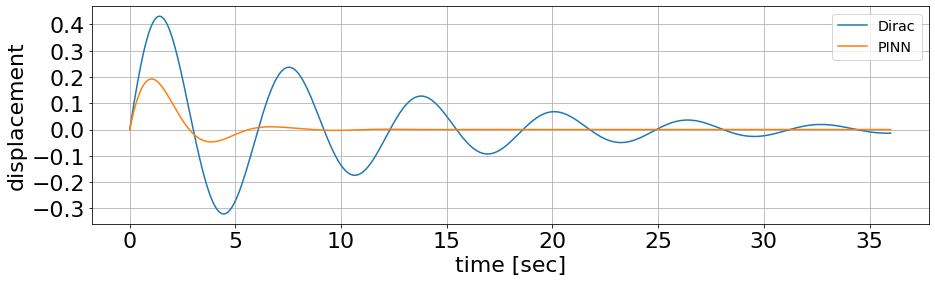

In [37]:
#%% Prediction
time_tensor = torch.tensor(time)
params = {'axes.labelsize': 22,
          'axes.titlesize': 16,
         'legend.fontsize': 'x-large'}
plt.rcParams.update(params)
grid_sampler = tp.samplers.GridSampler(A_t, n_points=len(rk_solu)) #+ tp.samplers.GridSampler(A_t.boundary, n_points=1)
grid_points = grid_sampler.sample_points()
                        # )
model_out = model(grid_points)
pinn_solu = pd.Series(np.interp(rk_solu.index, grid_points.as_tensor.detach().numpy().ravel(), 
                                model_out.as_tensor.detach().numpy().ravel()),
                      index=rk_solu.index, name="PINN"
                     )
solu_comb = pd.concat((rk_solu[_eval], pinn_solu), axis=1)
solu_comb.plot(marker=None, figsize=(15,4), fontsize=22, ylabel="displacement",
              xlabel="time [sec]", grid=True)

In [33]:
pinn_solu

time
0.00000     0.018242
0.03125     0.017913
0.06250     0.017820
0.09375     0.017713
0.12500     0.017583
              ...   
35.87500   -0.001128
35.90625   -0.001195
35.93750   -0.001258
35.96875   -0.001317
36.00000   -0.001317
Name: PINN, Length: 1153, dtype: float64

### Some validation

                0           1           2
count  577.000000  577.000000  577.000000
mean     0.054034   -0.014500   -0.057316
std      0.946844    1.036568    1.035195
min     -2.975134   -2.630992   -3.594237
25%     -0.589076   -0.686592   -0.742322
50%      0.067919   -0.006340   -0.018100
75%      0.728967    0.718518    0.626640
max      2.695139    2.839369    3.430359


<AxesSubplot:xlabel='time'>

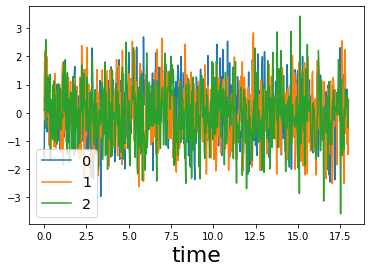

In [17]:
tend_val = int(.5 * t_end)
time_val = np.linspace(0, tend_val, tend_val*sampling_frequency + 1)
Fval = pd.DataFrame(np.random.randn(time_val.shape[0], 3),
              index=pd.Index(time_val, name="time"),
#               index=["wn", "SineSweep", "SoR"]
              )
print(Fval.describe())
Fval.plot()

In [18]:
func_f_val = Fval.apply(interfunc)
rk_solu_val = func_f_val.apply(get_rk_solution, **{"t_1" : tend_val, "time_eval" : time_val}).T

In [19]:
A_t_val = tp.domains.Interval(T, 0, tend_val)
grid_sampler = tp.samplers.GridSampler(A_t_val, n_points=len(time_val))
grid_points = grid_sampler.sample_points()
pinn_val_pinn = model(grid_points)
pinn_eval = pd.Series(np.interp(time_val, grid_points.as_tensor.detach().numpy().ravel(), 
                                pinn_val_pinn.as_tensor.detach().numpy().ravel()),
                      index=pd.Index(time_val, name="time"), name="PINN"
                     )
# pinn_eval = pd.Series(pinn_val_pinn.as_tensor.detach().numpy().ravel(), index=grid_points.as_tensor.detach().numpy().ravel())

<AxesSubplot:xlabel='time'>

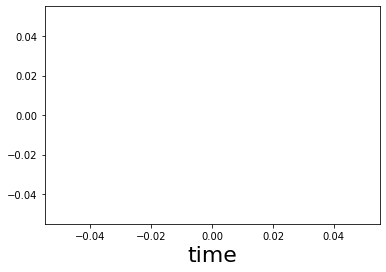

In [20]:
pinn_eval.plot()

In [21]:
from scipy.signal import convolve

In [22]:
# len(time_val)
u_val = Fval.transform(lambda x: np.convolve(x, pinn_eval, 'same'))
#                        convolve(pinn_eval, Fval.iloc[:, 0],
#                   mode="same",
# #                   mode="full",
#                  )

<AxesSubplot:xlabel='time'>

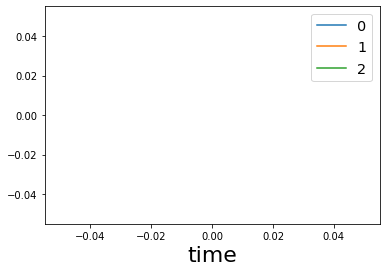

In [23]:
u_val.plot()

In [24]:
pd.DataFrame(u_val)

,0,1,2
time,,,
0.00000,NaN,NaN,NaN
0.03125,NaN,NaN,NaN
0.06250,NaN,NaN,NaN
0.09375,NaN,NaN,NaN
0.12500,NaN,NaN,NaN
...,...,...,...
17.87500,NaN,NaN,NaN
17.90625,NaN,NaN,NaN
17.93750,NaN,NaN,NaN


<AxesSubplot:xlabel='time'>

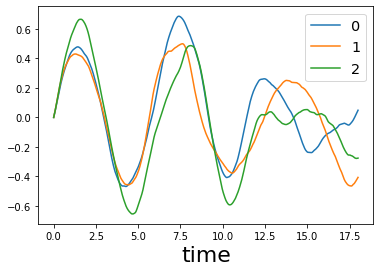

In [25]:
rk_solu_val.plot()

In [26]:
rk_solu_val.shape

(577, 3)

In [27]:
len(time_val)

577